<a href="https://colab.research.google.com/github/raghavadevarajeurs/DeepLearning/blob/main/Assignment5/NYC_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

In [20]:
!wget https://raw.githubusercontent.com/raghavadevarajeurs/DeepLearning/main/Assignment5/Data/train.csv

--2021-04-19 06:10:44--  https://raw.githubusercontent.com/raghavadevarajeurs/DeepLearning/main/Assignment5/Data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5424127 (5.2M) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]   5.17M  --.-KB/s    in 0.06s   

2021-04-19 06:10:44 (84.7 MB/s) - ‘train.csv.1’ saved [5424127/5424127]



In [21]:
from geopy.distance import geodesic
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F

In [22]:
df = pd.read_csv('/content/train.csv')
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
49995,2013-06-12 23:25:15.0000004,15.0,2013-06-12 23:25:15 UTC,-73.999973,40.748531,-74.016899,40.705993,1
49996,2015-06-22 17:19:18.0000007,7.5,2015-06-22 17:19:18 UTC,-73.984756,40.768211,-73.987366,40.760597,1
49997,2011-01-30 04:53:00.00000063,6.9,2011-01-30 04:53:00 UTC,-74.002698,40.739428,-73.998108,40.759483,1
49998,2012-11-06 07:09:00.00000069,4.5,2012-11-06 07:09:00 UTC,-73.946062,40.777567,-73.953450,40.779687,2


In [23]:
df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format= "%Y-%m-%d %H:%M:%S UTC")
df['trip_start_month'] = df['pickup_datetime'].dt.month
df['trip_start_hour'] = df['pickup_datetime'].dt.hour
df['trip_start_day'] = df['pickup_datetime'].dt.day
df = df.rename(columns={'fare_amount': 'fare'})

In [24]:
df = df[(df['pickup_longitude'] <= -73.8)]
df = df[(df['pickup_latitude'] < 40.9)]
df = df[(df['dropoff_longitude'] <= -73.8)]
df = df[(df['dropoff_latitude'] < 40.9)]

df = df[(df['dropoff_longitude'] > -74.2)]
df = df[(df['pickup_longitude'] > -74.2)]
df = df[(df['pickup_latitude'] > 40.5)]
df = df[(df['dropoff_latitude'] > 40.5)]

In [25]:
df_features = df.copy()
df_features['pickup_datetime'] = pd.to_datetime(df_features['pickup_datetime'])
df_features['month'] = df_features['pickup_datetime'].dt.month
df_features['day'] = df_features['pickup_datetime'].dt.day
df_features['distance'] = df_features.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).miles, axis=1)
df_features

,key,fare,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_start_month,trip_start_hour,trip_start_day,month,day,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,6,17,15,6,15,0.639764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,1,16,5,1,5,5.246511
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,8,0,18,8,18,0.863167
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,4,21,4,21,1.737223
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,3,7,9,3,9,1.241710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2013-06-12 23:25:15.0000004,15.0,2013-06-12 23:25:15,-73.999973,40.748531,-74.016899,40.705993,1,6,23,12,6,12,3.066758
49996,2015-06-22 17:19:18.0000007,7.5,2015-06-22 17:19:18,-73.984756,40.768211,-73.987366,40.760597,1,6,17,22,6,22,0.542939
49997,2011-01-30 04:53:00.00000063,6.9,2011-01-30 04:53:00,-74.002698,40.739428,-73.998108,40.759483,1,1,4,30,1,30,1.404655
49998,2012-11-06 07:09:00.00000069,4.5,2012-11-06 07:09:00,-73.946062,40.777567,-73.953450,40.779687,2,11,7,6,11,6,0.414219


In [26]:
label_col = 'fare'
X = df_features[['passenger_count', 'distance', 'month', 'day']].to_numpy()
y = df_features[[label_col]].to_numpy()

inputs = torch.tensor(X, dtype=torch.float32)
targets = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(inputs, targets)

data, label = dataset[0]
print(data, data.shape, label)

tensor([ 1.0000,  0.6398,  6.0000, 15.0000]) torch.Size([4]) tensor([4.5000])


In [27]:
validation_part = 0.1
validation_size = int(validation_part * len(dataset))
train_size = len(dataset) - validation_size
train_ds, val_ds = random_split(dataset, [train_size, validation_size])
print(len(train_ds), len(val_ds))

42977 4775


In [28]:
batch_size = 32

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [29]:
class NeuralNet(nn.Module):
  def __init__(self, Dim_in, Dim_hid, Dim_out, n_continuous, n_categorical):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    Dim_in: input dimension
    Dim_hid: dimension of hidden layer
    Dim_out: output dimension
    """
    super(NeuralNet, self).__init__()
    self.linear_deep1 = nn.Linear(n_continuous, Dim_hid) 
    self.linear_deep2 = nn.Linear(Dim_hid, Dim_hid)
    self.linear_final3 = nn.Linear(n_continuous + n_categorical, 1)
    self.n_continuous = n_continuous
    self.n_categorical = n_categorical

  def __call__(self, x):
    """
    In the forward function we accept a Variable of input data and we must 
    return a Variable of output data. We can use Modules defined in the 
    constructor as well as arbitrary operators on Variables.
    """
    continuous_features = x[:,range(self.n_continuous)]
    categorical_features = x[:,range(self.n_continuous, self.n_continuous + self.n_categorical)]

    relu1 = F.relu(self.linear_deep1(continuous_features))
    relu2 = F.relu(self.linear_deep2(relu1))

    x = torch.cat((relu2, categorical_features), dim=1)
    y_pred = self.linear_final3(x)
    return y_pred

In [30]:
# Dim_in: input dimension;
# Dim_hid: dimension of the hidden layer
# Dim_out: output dimension.
Dim_in, Dim_hid, Dim_out = data.shape[0], 2, 1
print(Dim_in, Dim_hid, Dim_out)

model = NeuralNet(Dim_in, Dim_hid, Dim_out, 2, 2)

4 2 1


In [31]:
# options
epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lmbda = lambda epoch: 0.95
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

for epoch in range(epochs):
  running_loss = 0.0
  for batch_id, (X_train, y_train) in enumerate(train_loader, 0):
    optimizer.zero_grad()

    y_pred = model(X_train)

    # Compute and print loss
    loss = criterion(y_pred, y_train)
    print(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()

Streaming output truncated to the last 5000 lines.
tensor(235.8942, grad_fn=<MseLossBackward>)
tensor(170.1914, grad_fn=<MseLossBackward>)
tensor(198.9315, grad_fn=<MseLossBackward>)
tensor(211.7258, grad_fn=<MseLossBackward>)
tensor(326.4021, grad_fn=<MseLossBackward>)
tensor(240.3596, grad_fn=<MseLossBackward>)
tensor(160.8519, grad_fn=<MseLossBackward>)
tensor(381.4899, grad_fn=<MseLossBackward>)
tensor(160.2226, grad_fn=<MseLossBackward>)
tensor(223.8360, grad_fn=<MseLossBackward>)
tensor(244.5518, grad_fn=<MseLossBackward>)
tensor(478.3983, grad_fn=<MseLossBackward>)
tensor(263.7549, grad_fn=<MseLossBackward>)
tensor(208.6454, grad_fn=<MseLossBackward>)
tensor(192.1437, grad_fn=<MseLossBackward>)
tensor(291.5555, grad_fn=<MseLossBackward>)
tensor(199.7774, grad_fn=<MseLossBackward>)
tensor(167.3522, grad_fn=<MseLossBackward>)
tensor(123.5885, grad_fn=<MseLossBackward>)
tensor(180.6280, grad_fn=<MseLossBackward>)
tensor(214.0734, grad_fn=<MseLossBackward>)
tensor(173.0753, grad_fn=

In [36]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47752 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                47752 non-null  object        
 1   fare               47752 non-null  float64       
 2   pickup_datetime    47752 non-null  datetime64[ns]
 3   pickup_longitude   47752 non-null  float64       
 4   pickup_latitude    47752 non-null  float64       
 5   dropoff_longitude  47752 non-null  float64       
 6   dropoff_latitude   47752 non-null  float64       
 7   passenger_count    47752 non-null  int64         
 8   trip_start_month   47752 non-null  int64         
 9   trip_start_hour    47752 non-null  int64         
 10  trip_start_day     47752 non-null  int64         
 11  month              47752 non-null  int64         
 12  day                47752 non-null  int64         
 13  distance           47752 non-null  float64       
dtypes: dat

In [37]:
df_features['AMorPM'] = np.where(df_features['trip_start_hour']<12,'am','pm')

In [39]:
df_features['EDTdate'] = pd.to_datetime(df_features['pickup_datetime']) - pd.Timedelta(hours=4)

In [41]:
df_features['Weekday'] = df_features['EDTdate'].dt.strftime("%a")

In [42]:
df_features.head()

,key,fare,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_start_month,trip_start_hour,trip_start_day,month,day,distance,AMorPM,EDTdate,Weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,6,17,15,6,15,0.639764,pm,2009-06-15 13:26:21,Mon
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,1,16,5,1,5,5.246511,pm,2010-01-05 12:52:16,Tue
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,8,0,18,8,18,0.863167,am,2011-08-17 20:35:00,Wed
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,4,21,4,21,1.737223,am,2012-04-21 00:30:42,Sat
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,3,7,9,3,9,1.241710,am,2010-03-09 03:51:00,Tue


In [43]:
cat_cols = ['trip_start_hour', 'AMorPM','Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']

In [46]:
from sklearn.preprocessing import LabelEncoder

In [47]:
for col in df_features.columns:
  if col in cat_cols:
    df_features[col] = LabelEncoder().fit_transform(df_features[col])
    df_features[col]= df_features[col].astype('category')

In [48]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47752 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                47752 non-null  object        
 1   fare               47752 non-null  float64       
 2   pickup_datetime    47752 non-null  datetime64[ns]
 3   pickup_longitude   47752 non-null  float64       
 4   pickup_latitude    47752 non-null  float64       
 5   dropoff_longitude  47752 non-null  float64       
 6   dropoff_latitude   47752 non-null  float64       
 7   passenger_count    47752 non-null  int64         
 8   trip_start_month   47752 non-null  int64         
 9   trip_start_hour    47752 non-null  category      
 10  trip_start_day     47752 non-null  int64         
 11  month              47752 non-null  int64         
 12  day                47752 non-null  int64         
 13  distance           47752 non-null  float64       
 14  AMorPM

In [49]:
df1 = df_features[['trip_start_hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']]

In [76]:
df_train = df1[:40000]
df_test = df1[40000:]

In [77]:
#Normalizing 

from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df_features):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance']
  for n in cont_names:
    assert is_numeric_dtype(df_features[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df_features[n].mean(),df_features[n].std()
    df_features[n] = (df_features[n]-means[n]) / (1e-7 + stds[n])


Normalize(df_train)
Normalize(df_test)
X = df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [78]:
df_train.head()

,trip_start_hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance
0,17,1,1,-1.316196,5.451187,-1.390403,4.874728,-0.516538,-0.726485
1,16,1,5,-1.739191,-1.524414,1.027346,-0.099129,-0.516538,2.019589
2,0,0,6,0.371011,-0.171431,-0.062905,-0.531774,0.260503,-0.593315
3,4,0,2,-0.816846,-0.349825,0.198197,-0.543517,-0.516538,-0.072291
4,7,0,5,0.655570,0.423338,1.088305,0.717923,-0.516538,-0.367666


In [79]:
X.shape

(40000, 9)

In [86]:
Y = np.log(df_features.fare)[:40000]

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [87]:
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42,shuffle=True ) 
X_train.head()

,trip_start_hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance
14991,18,1,3,0.764148,-0.371921,0.871690,-0.087423,-0.516538,-0.712987
18657,19,1,6,-1.325656,-0.879036,0.663155,0.862487,0.260503,1.443054
11530,13,1,5,0.345038,0.194781,0.477851,0.385256,-0.516538,-0.773716
15883,0,0,2,0.166482,0.458757,-1.448588,1.438323,0.260503,1.005010
26165,15,1,5,2.042761,-1.361942,3.666149,-3.371785,2.591625,1.859649


## Model

Pytorch data set datasets and dataloaders

In [90]:
X_train.head()

,trip_start_hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance
14991,18,1,3,0.764148,-0.371921,0.871690,-0.087423,-0.516538,-0.712987
18657,19,1,6,-1.325656,-0.879036,0.663155,0.862487,0.260503,1.443054
11530,13,1,5,0.345038,0.194781,0.477851,0.385256,-0.516538,-0.773716
15883,0,0,2,0.166482,0.458757,-1.448588,1.438323,0.260503,1.005010
26165,15,1,5,2.042761,-1.361942,3.666149,-3.371785,2.591625,1.859649


In [91]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        
        
        self.dfcats = df[cats] #type: pandas.core.frame.DataFrame
        self.dfconts = df.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
        
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) #tpye: numpy.ndarray
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) #tpye: numpy.ndarray
        self.y = y.values.astype(np.float32)
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [92]:
trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) #type: __main__.RegressionColumnarDataset
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) #type: __main__.RegressionColumnarDataset

In [102]:
params = {'batch_size': 128,
          'shuffle': True}


traindl = DataLoader(trainds, **params) #type: torch.utils.data.dataloader.DataLoader
valdl = DataLoader(valds, **params) #type: torch.utils.data.dataloader.DataLoader

In [93]:
# help functions

from collections.abc import Iterable

def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #type: torch.nn.modules.container.ModuleList
        self.emb_drop = nn.Dropout(emb_drop) #type: torch.nn.modules.dropout.Dropout
        self.bn_cont = nn.BatchNorm1d(n_cont) #type torch.nn.modules.batchnorm.BatchNorm1d
        n_emb = sum(e.embedding_dim for e in self.embeds) # n_emb = 17 , type: int
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] #typeL list, len: 4
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] #type: list, len: 3.  the last in None because we finish with linear
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) #type: torch.nn.modules.container.Sequential

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.emb_drop(x) # pass it through a dropout layer
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) # batchnorm1d
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()

In [94]:
torch.manual_seed(33)

In [95]:
y_range = (0, y_train.max()*1.2)
y_range

(0, 5.828141483133595)

In [96]:
cat_szs = [len(df_features[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [97]:
from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [98]:
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=250, out_features=1, bias=

In [99]:
opt = torch.optim.Adam(model.parameters(), lr=1e-2) # can add: weight_decay=
#lr_cosine = lr_scheduler.CosineAnnealingLR(opt,T_max = 350) #1000 ## if you want to add lr_cosine

lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

In [106]:
lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)

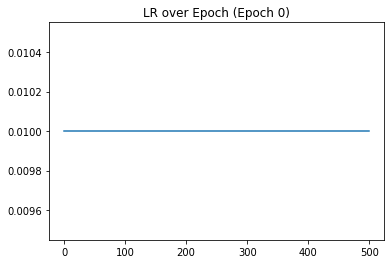

In [107]:
_ = plt.plot(lr[0])
_ = plt.title('LR over Epoch (Epoch 0)')